## k-means clustering for river detection in satellite imagery

Jenny Woods March 2020

The following code takes a Sentinel-2 image (L1C MSI AOI clipped) of the Amazon from UP42, and applies a simple k-means clustering to identify the river in the image.

N.B. This is not in general a good way to identify rivers in images (a supervised approach, i.e. training with labelled images, using a neural network would be better), rather is just a quick demonstration of scikit learn k-means clustering with satellite imagery.

#### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show, show_hist

from sklearn.cluster import KMeans
from sklearn.utils import shuffle

### Read and view satellite image

#### Open tif image with rasterio

In [4]:
dataset = rasterio.open('Sentinel-2/b397f43e-9e06-43b6-a048-4c6c223c314e.tif')

for band in range(1,5):
    print('BAND %d: min %d / max %d' % (band, dataset.read(band).min(), dataset.read(band).max()))

BAND 1: min 1 / max 255
BAND 2: min 69 / max 255
BAND 3: min 155 / max 255
BAND 4: min 255 / max 255


#### Have a look at the data

* B01	10 m	Red, 664.6 nm (S2A), 664.9 nm (S2B)
* B02	10 m	Green, 559.8 nm (S2A), 559.0 nm (S2B)
* B03	10 m	Blue, 492.4 nm (S2A), 492.1 nm (S2B)
* B04	10 m	Alpha

Band info from block page: https://marketplace.up42.com/block/3a381e6b-acb7-4cec-ae65-50798ce80e64

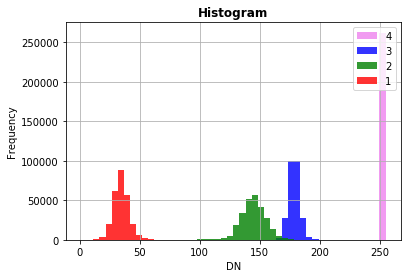

In [5]:
show_hist(dataset, bins=50, histtype='stepfilled',lw=0.0, stacked=False, alpha=0.8)

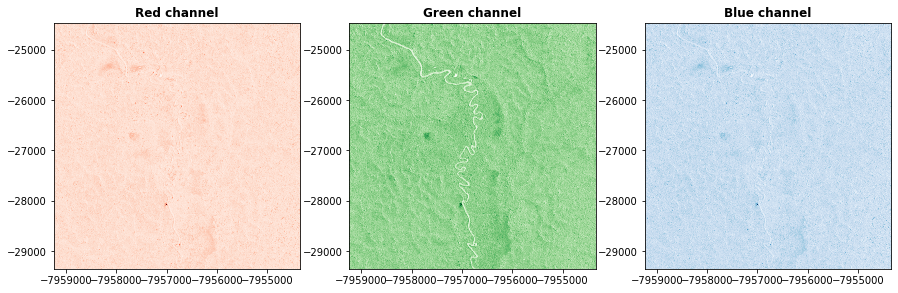

In [6]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(15,5))
show((dataset, 1), ax=axr, cmap='Reds', title='Red channel')
show((dataset, 2), ax=axg, cmap='Greens', title='Green channel')
show((dataset, 3), ax=axb, cmap='Blues', title='Blue channel')
plt.show()

### Apply k-means clustering to idenitfy river

#### First, reshape and normalise data

Here using just green channel (band 2), where river feature most prominent.

For all RGB channels, use:

    pixels = np.stack((dataset.read(1), dataset.read(2), dataset.read(3)), axis=-1)
    w, h, d = original_shape = pixels.shape

    # reshape to 2D array of pixels each with 3 colour values (RGB)
    pixels = pixels.reshape((-1,d))

In [7]:
pixels = dataset.read(2) # band 2 - green
w, h = original_shape = pixels.shape

# reshape to 2D array of pixels each with single green value
pixels = pixels.reshape((-1,1))

print(original_shape, '-->', pixels.shape)

(512, 512) --> (262144, 1)


In [8]:
# convert values to float and normalize 0-1
pixels = np.float32(pixels) / 255

#### Fit model

Fit model for n clusters on a subsample of the data, and extrapolate to all pixels.

In [9]:
n_clusters=6
samplesize=2000

# Fit model for n_clusters on subsample of size samplesize
pixels_sample = shuffle(pixels, random_state=0)[:samplesize]
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pixels_sample)

# Predict labels for all pixels
labels = kmeans.predict(pixels)

#### Plot individual labels

In [ ]:
fig, axs = plt.subplots(n_clusters, figsize=(5,30))

for i in range(n_clusters):
    axs[i].imshow((labels.reshape([w,h]) == i).astype(int))

### Plot original image vs river cluster

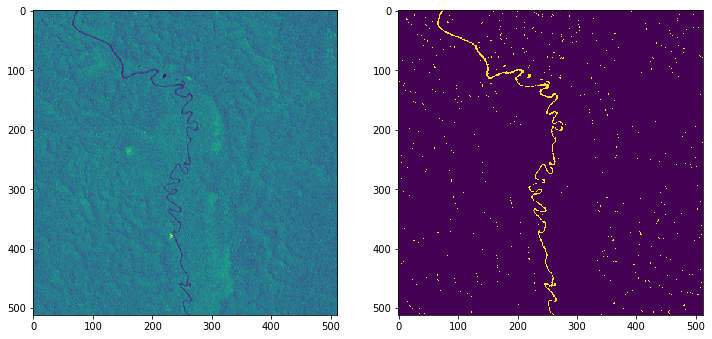

In [11]:
cluster=3 # cluster identifying river
fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].imshow(dataset.read(2)) # plotting just green channel
axs[1].imshow((labels.reshape([w,h]) == cluster).astype(int))